# Analysis - Conditional Alpha

## Question - Does regime edge improve if we filter by vol / benchmark strength / macro?”

What NB2 should conclude (what you’re looking for)

You want to end NB2 with one of these statements per ticker (or cross-ticker):
- “Buy bucket 1–2 only when RS is strong (rs_tercile=3)”
- “Fade overextended only when vol is high (vol_tercile=3)”
- “Momentum works in low vol only”

Those become production mart filters and later backtest rules  
Questions:
- Does the regime edge depend on volatility regime?  
- Does it depend on benchmark relative strength (risk-on vs risk-off)?  
- Optional: does it depend on macro (Fear & Greed / macro risk score)?

### 1. Imports + config

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery

### 2. Load env + credentials

In [14]:
PROJECT_ID = os.getenv("GCP_PROJECT_ID")
KEY_PATH = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

print("GCP_PROJECT_ID =", PROJECT_ID)
print("GOOGLE_APPLICATION_CREDENTIALS =", KEY_PATH)

DATASET_CORE  = "mag7_intel_core"
FACT_REGIMES  = "fact_regimes"
FACT_PRICES   = "fact_prices"
FACT_MACRO   = "fact_macro_sentiment_daily"

T_FACT_REGIMES = f"`{PROJECT_ID}.{DATASET_CORE}.{FACT_REGIMES}`"
T_FACT_PRICES  = f"`{PROJECT_ID}.{DATASET_CORE}.{FACT_PRICES}`"
T_FACT_MACRO   = f"`{PROJECT_ID}.{DATASET_CORE}.{FACT_MACRO}`"

print(f"Targted Tables = {T_FACT_REGIMES}, {T_FACT_PRICES}, {T_FACT_MACRO}")

# Analysis params
TICKERS = None         # None = all tickers, or set like ["AAPL","MSFT"]
START_DATE = None      # "2015-01-01"
END_DATE   = None      # "2025-12-31"
MAX_ROWS   = None      # e.g. 2_000_000 if you want a hard cap

GCP_PROJECT_ID = robotic-weft-480502-c2
GOOGLE_APPLICATION_CREDENTIALS = /home/shpang/.keys/robotic-weft-480502-c2.json
Targted Tables = `robotic-weft-480502-c2.mag7_intel_core.fact_regimes`, `robotic-weft-480502-c2.mag7_intel_core.fact_prices`, `robotic-weft-480502-c2.mag7_intel_core.fact_macro_sentiment_daily`


### 3. BQ client

In [5]:
client = bigquery.Client(project=PROJECT_ID)

### 4. Load regimes + context (join fact_regimes to fact_prices)

Pulls the columns needed for conditional alpha analysis: regime labels + forward returns + context features.

In [6]:
def load_frame():
    where = ["r.regime_bucket_10 IS NOT NULL", "r.zscore_bucket_10 IS NOT NULL"]
    if TICKERS:
        tickers_sql = ", ".join([f"'{t}'" for t in TICKERS])
        where.append(f"r.ticker IN ({tickers_sql})")
    if START_DATE:
        where.append(f"r.trade_date >= DATE('{START_DATE}')")
    if END_DATE:
        where.append(f"r.trade_date <= DATE('{END_DATE}')")

    where_sql = " AND ".join(where)
    limit_sql = f"LIMIT {int(MAX_ROWS)}" if MAX_ROWS else ""

    sql = f"""
    SELECT
      r.trade_date,
      r.ticker,
      r.regime_bucket_10,
      r.zscore_bucket_10,
      r.zscore_regime_5,
      r.combined_regime_style,
      r.fwd_return_5d,
      r.fwd_return_20d,

      -- context from prices (wide)
      p.vola_60d,
      p.vola_20d,
      p.ndx_relative_strength_20d,
      p.ndx_excess_return_20d,
      p.ndxe_excess_return_20d
    FROM {T_FACT_REGIMES} r
    LEFT JOIN {T_FACT_PRICES} p
      USING (trade_date, ticker)
    WHERE {where_sql}
    {limit_sql}
    """

    df = client.query(sql).to_dataframe()
    df["trade_date"] = pd.to_datetime(df["trade_date"])
    df["regime_bucket_10"] = df["regime_bucket_10"].astype(int)
    df["zscore_bucket_10"] = df["zscore_bucket_10"].astype(int)
    return df

df = load_frame()
df.head(), df.shape

/home/shpang/miniconda3/envs/mag7/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


(  trade_date ticker  regime_bucket_10  zscore_bucket_10     zscore_regime_5  \
 0 2024-06-26   TSLA                 5                10  extreme_overbought   
 1 2024-06-26   NVDA                10                 5             neutral   
 2 2024-06-26  GOOGL                10                10  extreme_overbought   
 3 2024-06-26   AMZN                10                10  extreme_overbought   
 4 2024-06-26   MSFT                10                 8          overbought   
 
   combined_regime_style  fwd_return_5d  fwd_return_20d  vola_60d  vola_20d  \
 0               neutral       0.254723        0.121607  0.037565  0.023166   
 1               neutral       0.014873       -0.111709  0.034529  0.033836   
 2          overextended       0.010550       -0.090276  0.018014  0.011365   
 3          overextended       0.020557       -0.071071  0.014559  0.014495   
 4          overextended       0.019042       -0.074664  0.012021  0.011241   
 
    ndx_relative_strength_20d  ndx_excess_

### 5. Basic coverage check

In [7]:
print("Tickers:", df["ticker"].nunique())
print("Date range:", df["trade_date"].min().date(), "→", df["trade_date"].max().date())
print("Rows:", len(df))

# Ensure context cols exist
print(df[["vola_60d","ndx_relative_strength_20d"]].isna().mean())

Tickers: 7
Date range: 2020-01-03 → 2025-12-11
Rows: 10451
vola_60d                     0.00067
ndx_relative_strength_20d    0.00000
dtype: float64


### 6. Check 1 - Regime x Z-score base frame

In [32]:
sql = f"""
SELECT
  r.trade_date,
  r.ticker,
  r.regime_bucket_10,
  r.zscore_bucket_10,
  r.fwd_return_20d

FROM {T_FACT_REGIMES} r

WHERE r.regime_bucket_10 IS NOT NULL
  AND r.zscore_bucket_10 IS NOT NULL
"""

print(sql)


SELECT
  r.trade_date,
  r.ticker,
  r.regime_bucket_10,
  r.zscore_bucket_10,
  r.fwd_return_20d

FROM `robotic-weft-480502-c2.mag7_intel_core.fact_regimes` r

WHERE r.regime_bucket_10 IS NOT NULL
  AND r.zscore_bucket_10 IS NOT NULL



In [34]:
df_rz = client.query(sql).to_dataframe()

df_rz["regime_bucket_10"] = df_rz["regime_bucket_10"].astype(int)
df_rz["zscore_bucket_10"] = df_rz["zscore_bucket_10"].astype(int)

df_rz.head(), df_rz.shape

/home/shpang/miniconda3/envs/mag7/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


(   trade_date ticker  regime_bucket_10  zscore_bucket_10  fwd_return_20d
 0  2024-09-17   NVDA                 8                 4        0.138507
 1  2024-09-17  GOOGL                 5                 4        0.038539
 2  2024-09-17   AAPL                 8                 1        0.078694
 3  2024-09-17   MSFT                 7                10       -0.037711
 4  2024-09-17   AMZN                 8                 9        0.004334,
 (10451, 5))

In [40]:
rz_summary = (
    df_rz
    .groupby(["ticker", "zscore_bucket_10", "regime_bucket_10"])
    .agg(
        n=("fwd_return_20d", "size"),
        avg=("fwd_return_20d", "mean"),
        med=("fwd_return_20d", "median"),
        win=("fwd_return_20d", lambda x: (x > 0).mean()),
    )
    .reset_index()
)
rz_summary.head(), rz_summary.shape


(  ticker  zscore_bucket_10  regime_bucket_10   n       avg       med       win
 0   AAPL                 1                 1  34  0.052446  0.069750  0.705882
 1   AAPL                 1                 2  11 -0.019955 -0.010568  0.272727
 2   AAPL                 1                 3   6  0.010731  0.021021  0.666667
 3   AAPL                 1                 4   8  0.029712 -0.021519  0.375000
 4   AAPL                 1                 5  12 -0.023397 -0.054077  0.333333,
 (648, 7))

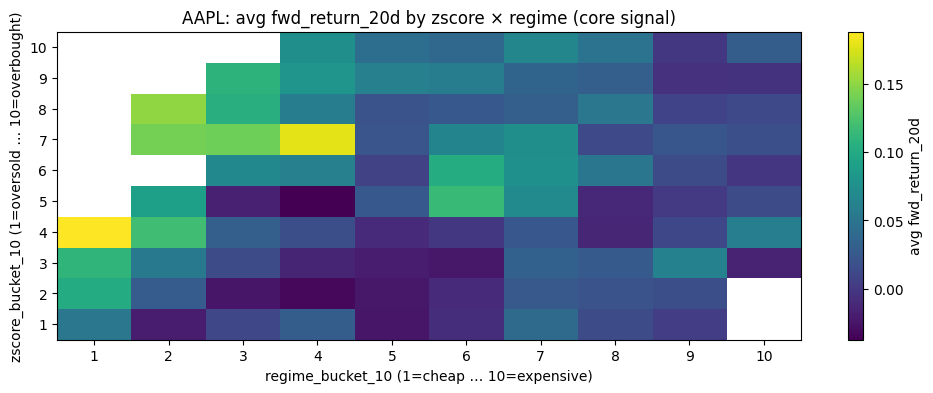

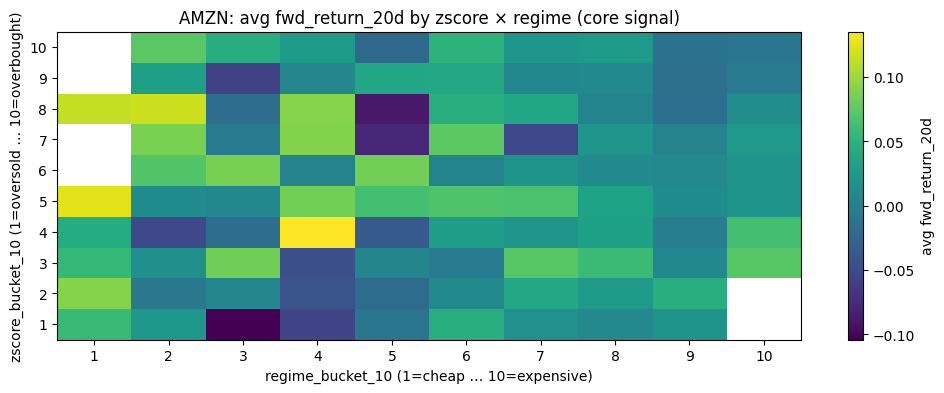

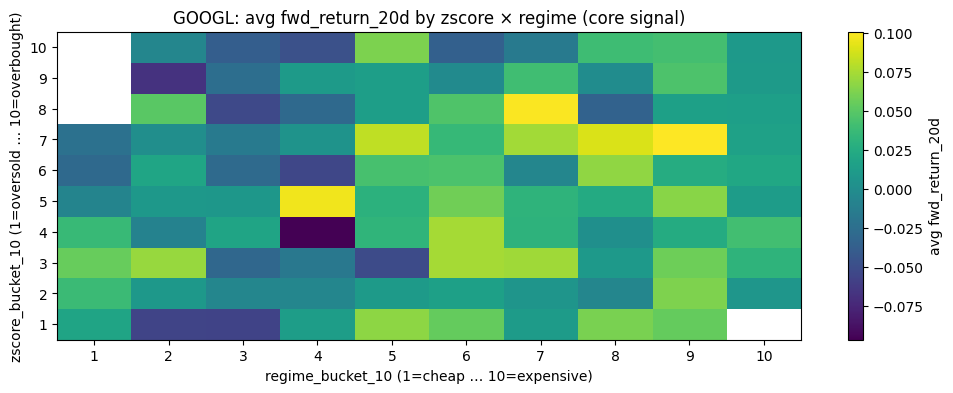

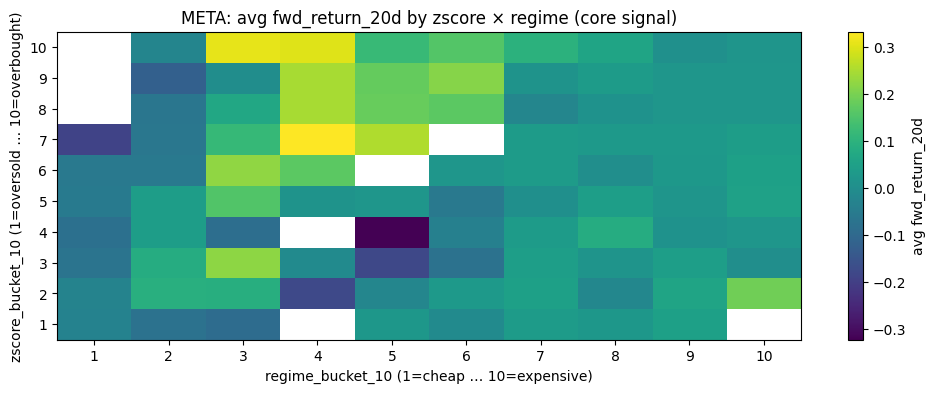

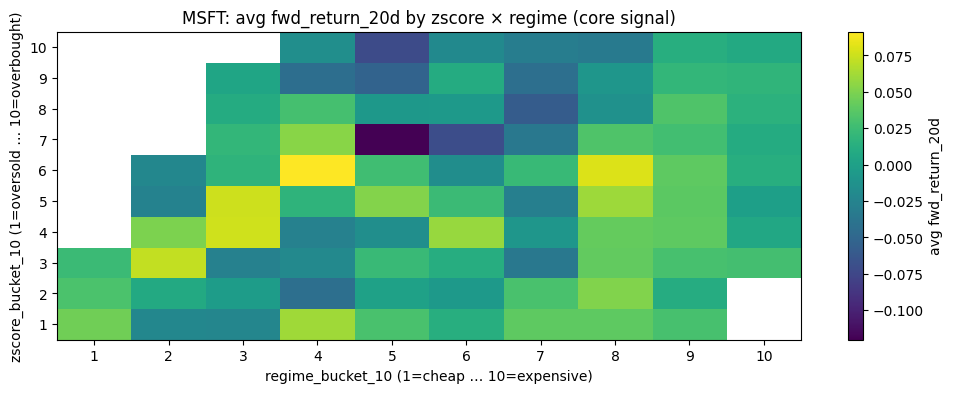

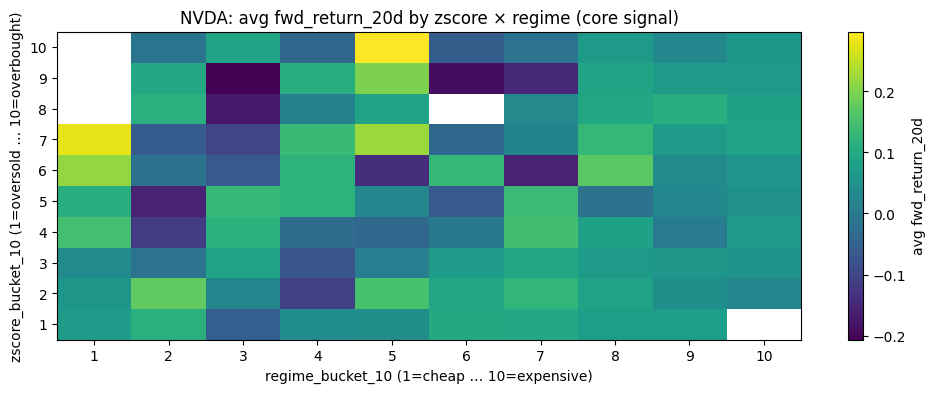

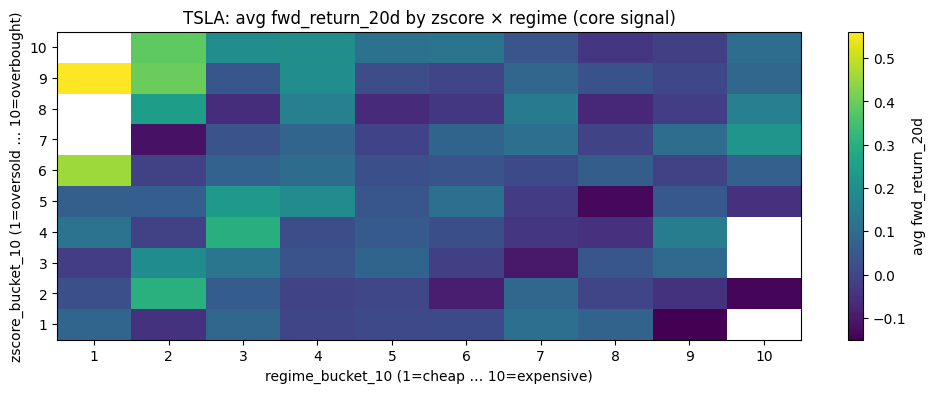

In [41]:
for t in sorted(rz_summary["ticker"].unique()):
    sub = rz_summary[rz_summary["ticker"] == t]

    piv = sub.pivot(
        index="zscore_bucket_10",
        columns="regime_bucket_10",
        values="avg"
    ).reindex(index=range(1,11), columns=range(1,11))

    plt.figure(figsize=(12, 4))
    im = plt.imshow(piv.values, aspect="auto", origin="lower")

    plt.title(f"{t}: avg fwd_return_20d by zscore × regime (core signal)")
    plt.xlabel("regime_bucket_10 (1=cheap … 10=expensive)")
    plt.ylabel("zscore_bucket_10 (1=oversold … 10=overbought)")
    plt.colorbar(im, label=f"avg fwd_return_20d")

    plt.xticks(range(10), range(1,11))
    plt.yticks(range(10), range(1,11))
    plt.show()


### 7. Check 2 - Conditional on volatility regime

##### 7.1 — Build vol terciles (per ticker)
- Take vola_60d and split it per ticker into 3 buckets

| vol_tercile | Meaning                |
| ----------- | ---------------------- |
| 1           | Low volatility regime  |
| 2           | Medium volatility      |
| 3           | High volatility regime |


In [8]:
df_vol = df.dropna(subset=["vola_60d"]).copy()

df_vol["vol_tercile"] = (
    df_vol.groupby("ticker")["vola_60d"]
          .transform(lambda s: pd.qcut(s, 3, labels=[1,2,3]))
          .astype(int)
)

df_vol[["ticker","vola_60d","vol_tercile"]].head()


,ticker,vola_60d,vol_tercile
0,TSLA,0.037565,2
1,NVDA,0.034529,2
2,GOOGL,0.018014,2
3,AMZN,0.014559,1
4,MSFT,0.012021,1


##### 7.2. — Aggregate forward returns (fwd_return_20d)
For each:
- ticker
- vol_tercile
- regime_bucket_10 (cheap → expensive)

Computed:
- avg fwd_return_20d
- win rate
- median
- sample size

In [9]:
vol_summary = (
    df_vol.groupby(["ticker","vol_tercile","regime_bucket_10"])
          .agg(
              n=("fwd_return_20d","size"),
              avg_20d=("fwd_return_20d","mean"),
              win_20d=("fwd_return_20d", lambda x: (x > 0).mean()),
              p50_20d=("fwd_return_20d","median")
          )
          .reset_index()
)
vol_summary.head()


,ticker,vol_tercile,regime_bucket_10,n,avg_20d,win_20d,p50_20d
0,AAPL,1,1,13,0.086266,0.923077,0.089165
1,AAPL,1,2,18,0.037361,0.555556,0.010407
2,AAPL,1,3,9,0.017147,0.444444,-0.017829
3,AAPL,1,4,7,0.065766,0.714286,0.077281
4,AAPL,1,5,5,-0.016967,0.200000,-0.051286


##### 7.3 Create Heatmap plot per ticker (avg_20d)
X-axis: regime_bucket_10
- 1 = near 200d low (cheap)
- 10 = near 200d high (expensive)  

Y-axis: vol_tercile
- 1 = low vol
- 3 = high vol  

Color: average 20-day forward return
- Yellow / green = positive
- Blue / purple = negative

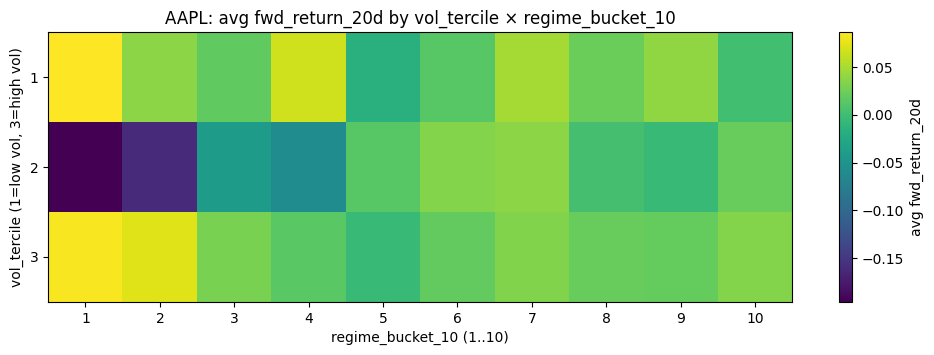

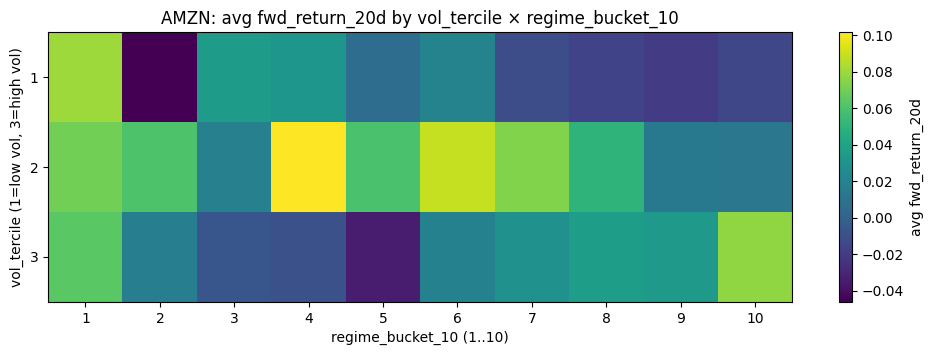

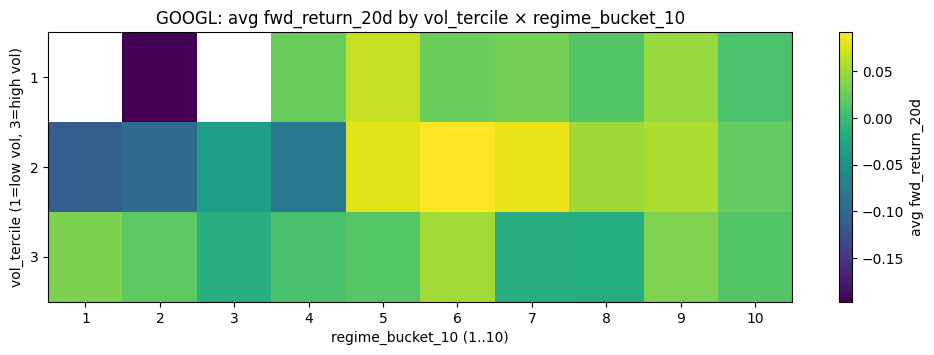

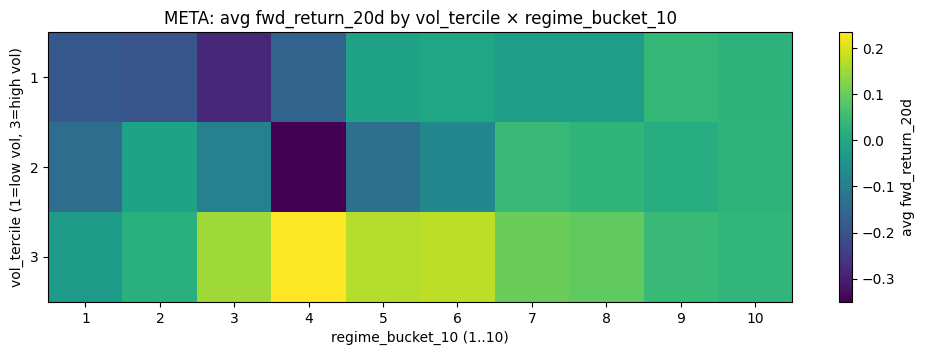

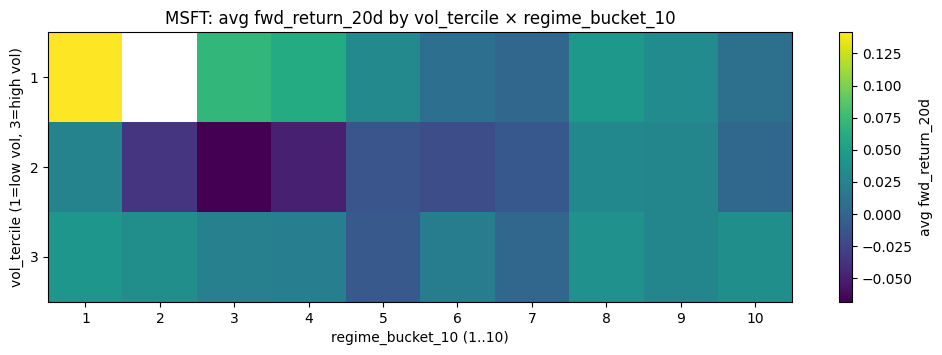

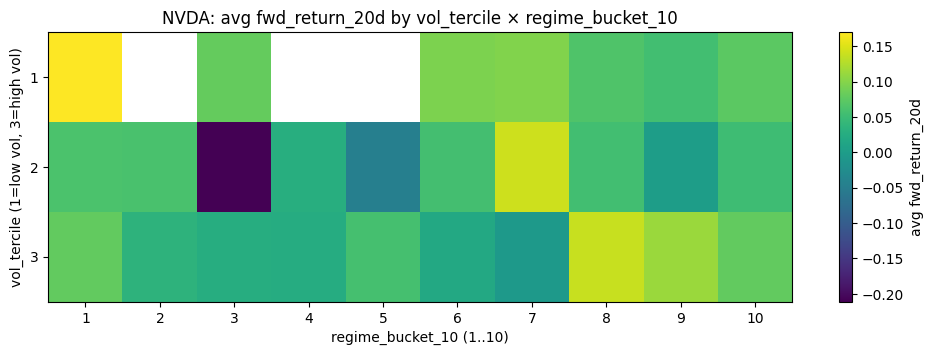

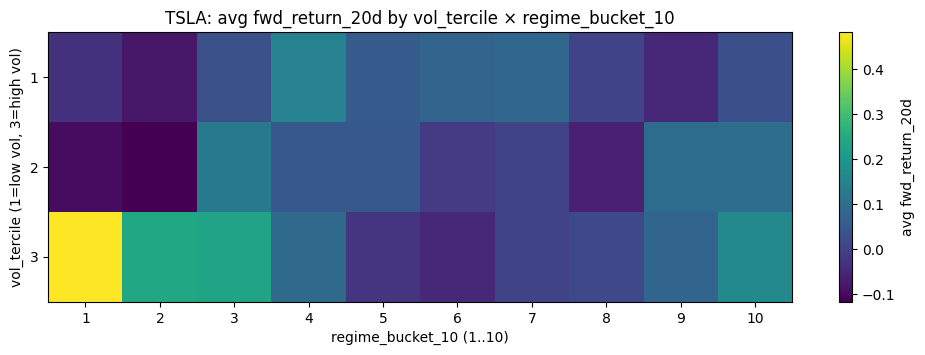

In [10]:
for t in sorted(df_vol["ticker"].unique()):
    sub = vol_summary[vol_summary["ticker"] == t]
    piv = sub.pivot(index="vol_tercile", columns="regime_bucket_10", values="avg_20d")
    plt.figure(figsize=(12, 3.5))
    plt.imshow(piv.values, aspect="auto")
    plt.title(f"{t}: avg fwd_return_20d by vol_tercile × regime_bucket_10")
    plt.xlabel("regime_bucket_10 (1..10)")
    plt.ylabel("vol_tercile (1=low vol, 3=high vol)")
    plt.colorbar(label="avg fwd_return_20d")
    plt.xticks(range(piv.shape[1]), piv.columns.tolist())
    plt.yticks(range(piv.shape[0]), piv.index.tolist())
    plt.show()


##### 7.4 Interpretation

##### 1. Volatility has weak influence to regime returns
- while some stocks shows ??

##### 2. Individual stock personalities

**TSLA**
- Strong positive returns in high vol + cheap
- Very poor results in low vol cheap buckets
- Interpretation - TSLA mean reverts violently, but only during chaos.

**NVDA**
- Strong returns across many regimes
- Particularly strong in high vol + mid/high buckets
- Interpretation - Structural momentum + strong dip buying demand.



### 8. Check 3 - Conditional on benchmark relative strength

Hypothesis
- Regime effectiveness depends on relative strength vs the benchmark (NDX).

Put differently:
- Is “cheap” the same when a stock is strong vs the index?
- Is “expensive” dangerous only when relative strength is weakening?
- Does momentum require leadership vs the benchmark?

##### 8.1 Build RS terciles

| rs_tercile | Meaning                       |
| ---------- | ----------------------------- |
| **1**      | Weak vs NDX (underperforming) |
| **2**      | Neutral                       |
| **3**      | Strong vs NDX (outperforming) |


In [11]:
df_rs = df.dropna(subset=["ndx_relative_strength_20d"]).copy()

df_rs["rs_tercile"] = (
    df_rs.groupby("ticker")["ndx_relative_strength_20d"]
         .transform(lambda s: pd.qcut(s, 3, labels=[1,2,3]))
         .astype(int)
)

df_rs[["ticker","ndx_relative_strength_20d","rs_tercile"]].head()


,ticker,ndx_relative_strength_20d,rs_tercile
0,TSLA,0.064210,2
1,NVDA,0.068986,2
2,GOOGL,-0.002405,2
3,AMZN,0.016737,2
4,MSFT,0.004426,2


##### 8.2 Summary: (rs_tercile × regime_bucket_10)
measured Average 20-day forward return (fwd_return_20d) for each (rs_tercile × regime_bucket_10)

In [12]:
rs_summary = (
    df_rs.groupby(["ticker","rs_tercile","regime_bucket_10"])
         .agg(
             n=("fwd_return_20d","size"),
             avg_20d=("fwd_return_20d","mean"),
             win_20d=("fwd_return_20d", lambda x: (x > 0).mean()),
             p50_20d=("fwd_return_20d","median")
         )
         .reset_index()
)
rs_summary.head()


,ticker,rs_tercile,regime_bucket_10,n,avg_20d,win_20d,p50_20d
0,AAPL,1,1,36,0.063455,0.805556,0.078306
1,AAPL,1,2,28,0.042262,0.535714,0.008020
2,AAPL,1,3,33,-0.000219,0.484848,-0.006218
3,AAPL,1,4,51,0.005329,0.627451,0.023052
4,AAPL,1,5,40,-0.012677,0.275000,-0.049769


##### 8.3 Heatmap plot per ticker (avg_20d)

For each ticker:
- X-axis: regime_bucket_10
    - 1 = near 200-day low
    - 10 = near 200-day high
- Y-axis: rs_tercile
    - 1 = weak vs NDX
    - 3 = strong vs NDX
- Color: avg 20-day forward return
    - Green / yellow = positive
    - Blue / purple = negative

Each row answers:
- “If the stock is weak/neutral/strong vs NDX, how does price regime perform?”

Each column answers:
- “At this price regime, does relative strength help or hurt?”

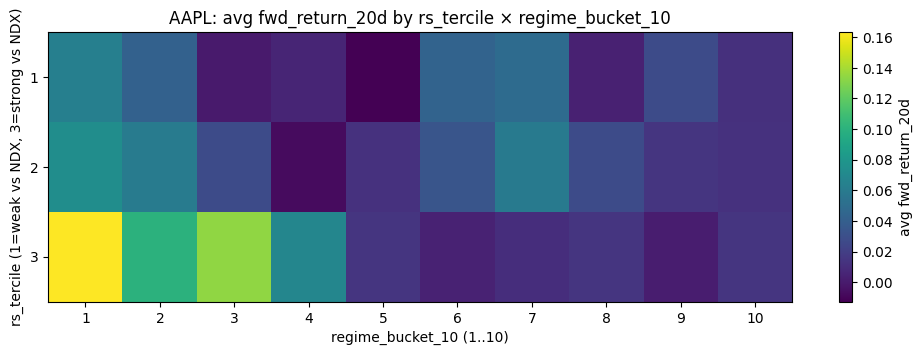

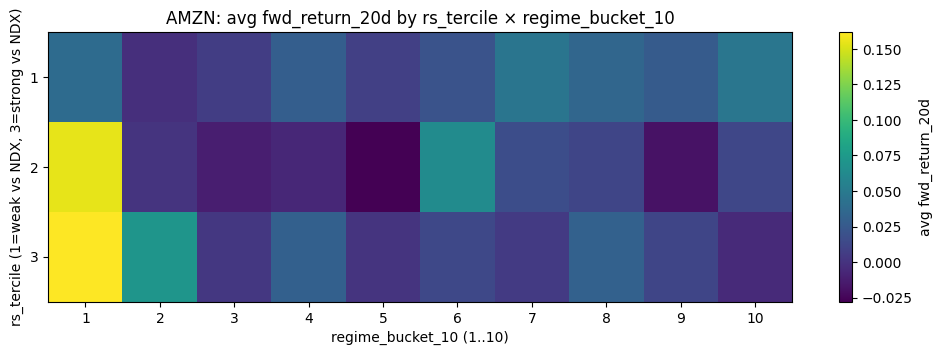

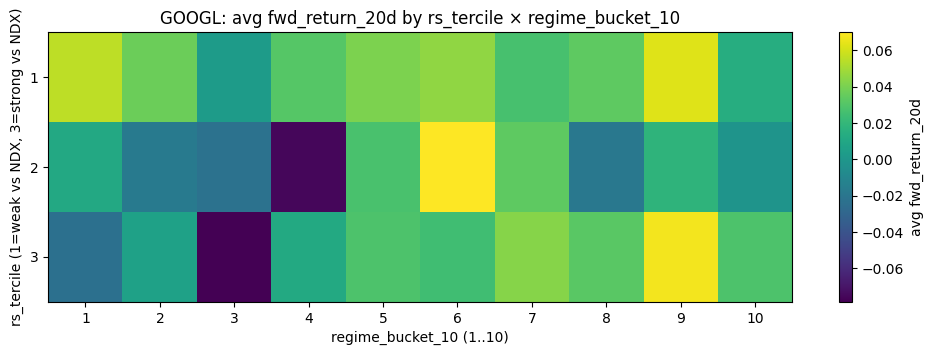

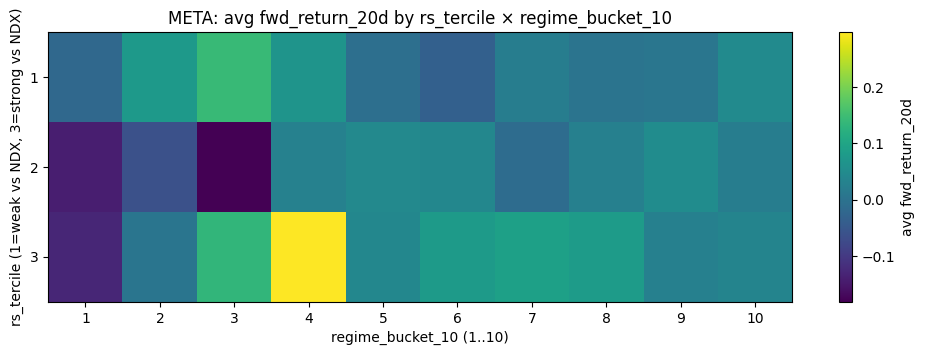

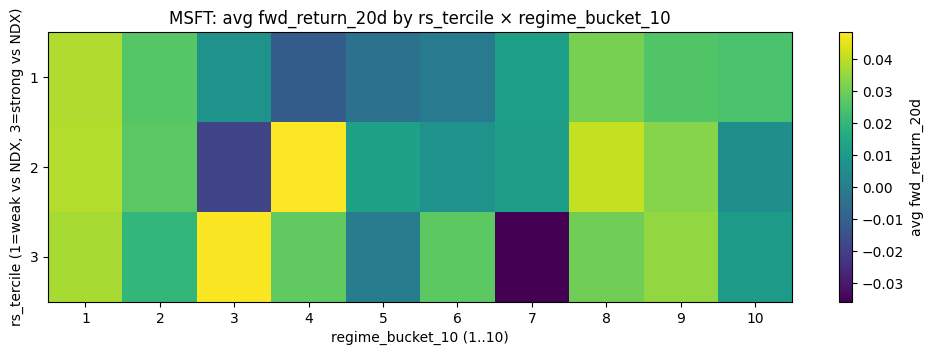

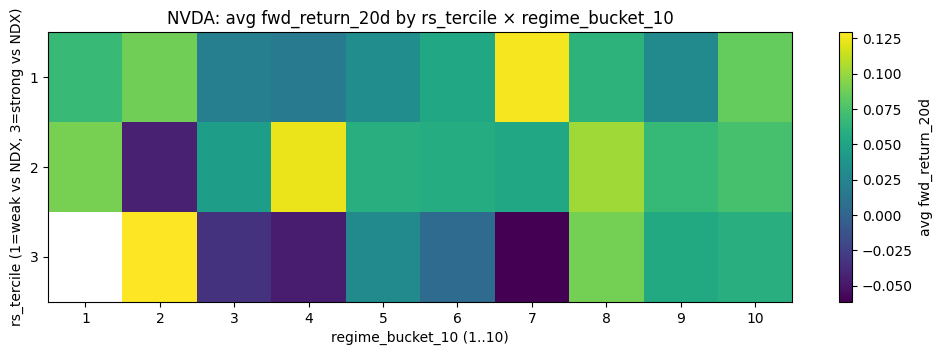

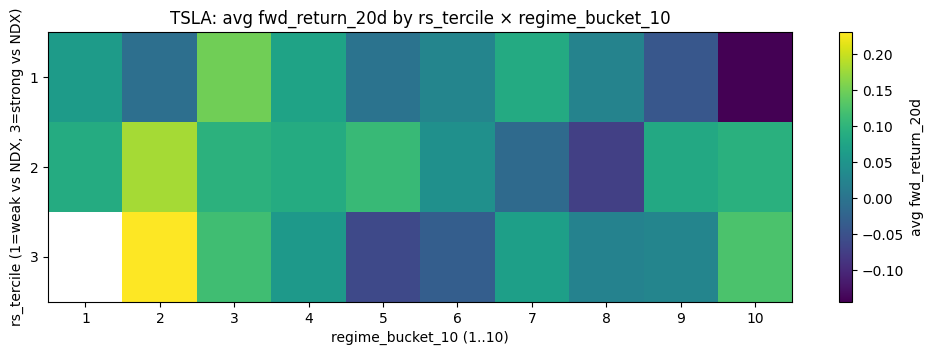

In [13]:
for t in sorted(df_rs["ticker"].unique()):
    sub = rs_summary[rs_summary["ticker"] == t]
    piv = sub.pivot(index="rs_tercile", columns="regime_bucket_10", values="avg_20d")
    plt.figure(figsize=(12, 3.5))
    plt.imshow(piv.values, aspect="auto")
    plt.title(f"{t}: avg fwd_return_20d by rs_tercile × regime_bucket_10")
    plt.xlabel("regime_bucket_10 (1..10)")
    plt.ylabel("rs_tercile (1=weak vs NDX, 3=strong vs NDX)")
    plt.colorbar(label="avg fwd_return_20d")
    plt.xticks(range(piv.shape[1]), piv.columns.tolist())
    plt.yticks(range(piv.shape[0]), piv.index.tolist())
    plt.show()


Interpretation:

If mean reversion buckets (1–2) work only when rs_tercile=3, that’s “buy dips only in risk-on tape”

If they work in rs_tercile=1, that’s “defensive mean reversion / capitulation”

### 9. Check 4 - Condition on macro Fear & Greed / macro risk

In [21]:
MACRO_COL = "fear_greed"

sql = f"""
SELECT
  r.trade_date, r.ticker, r.regime_bucket_10, r.zscore_bucket_10, r.fwd_return_20d,
  m.{MACRO_COL} AS macro_val
FROM {T_FACT_REGIMES} r
LEFT JOIN {T_FACT_MACRO} m USING (trade_date)
WHERE r.regime_bucket_10 IS NOT NULL
  AND r.zscore_bucket_10 IS NOT NULL
"""
df_macro = client.query(sql).to_dataframe()
df_macro["trade_date"] = pd.to_datetime(df_macro["trade_date"])
df_macro["regime_bucket_10"] = df_macro["regime_bucket_10"].astype(int)
df_macro["zscore_bucket_10"] = df_macro["zscore_bucket_10"].astype(int)

df_macro.head(), df_macro.shape

/home/shpang/miniconda3/envs/mag7/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


(  trade_date ticker  regime_bucket_10  zscore_bucket_10  fwd_return_20d  \
 0 2024-11-20  GOOGL                 8                 5        0.072429   
 1 2024-11-20   AMZN                 8                 5        0.100601   
 2 2024-11-20   META                 9                 3        0.053986   
 3 2024-11-20   MSFT                 4                 3        0.053948   
 4 2024-11-20   AAPL                 9                 6        0.090786   
 
    macro_val  
 0  49.514286  
 1  49.514286  
 2  49.514286  
 3  49.514286  
 4  49.514286  ,
 (10451, 6))

##### 9.2. Create Macro terciles and summary

In [22]:
df_macro = df_macro.dropna(subset=["macro_val"]).copy()
df_macro["macro_tercile"] = pd.qcut(df_macro["macro_val"], 3, labels=[1,2,3]).astype(int)

macro_summary = (
    df_macro.groupby(["ticker","macro_tercile","regime_bucket_10"])
            .agg(n=("fwd_return_20d","size"),
                 avg_20d=("fwd_return_20d","mean"),
                 win_20d=("fwd_return_20d", lambda x: (x > 0).mean()))
            .reset_index()
)
macro_summary.head()

,ticker,macro_tercile,regime_bucket_10,n,avg_20d,win_20d
0,AAPL,1,1,22,0.110420,1.000000
1,AAPL,1,2,7,0.104031,1.000000
2,AAPL,1,3,10,0.038631,0.700000
3,AAPL,1,4,14,-0.032526,0.214286
4,AAPL,1,5,13,-0.063528,0.076923


##### 9.3 Heatmap

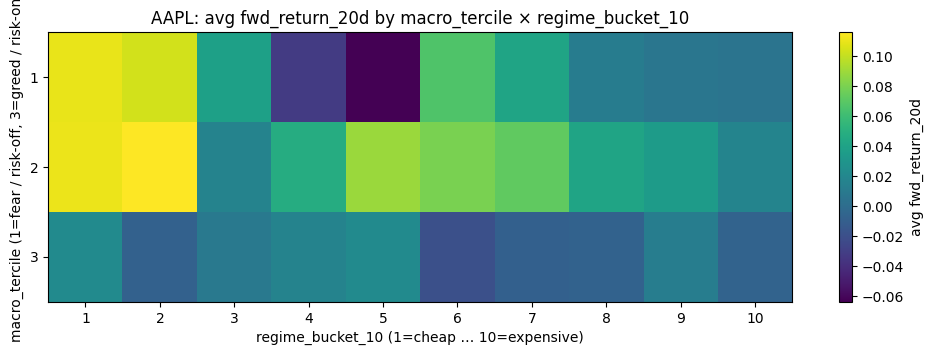

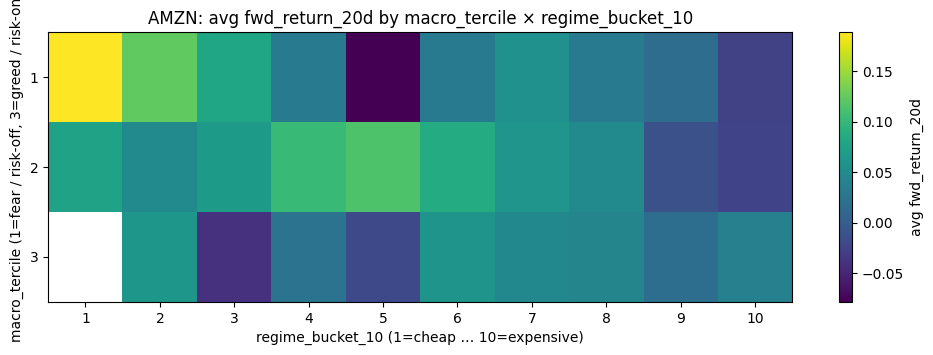

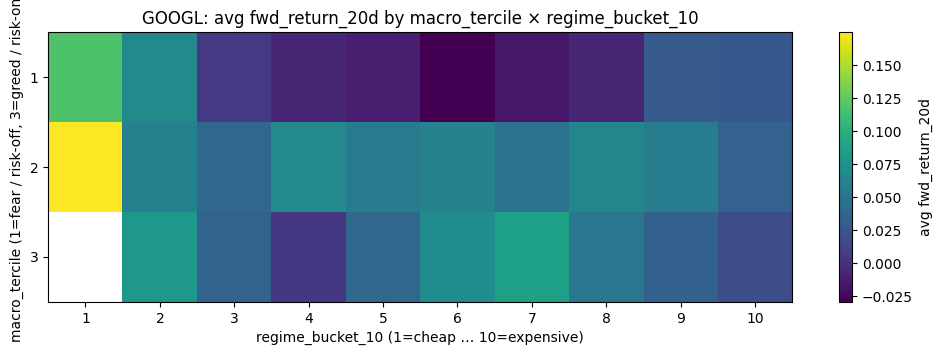

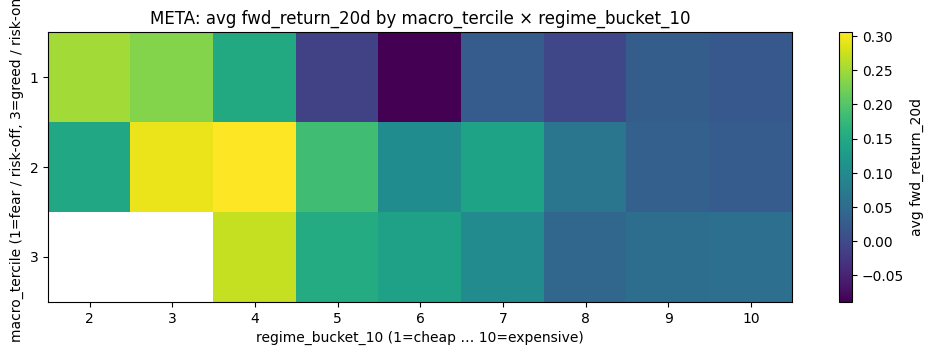

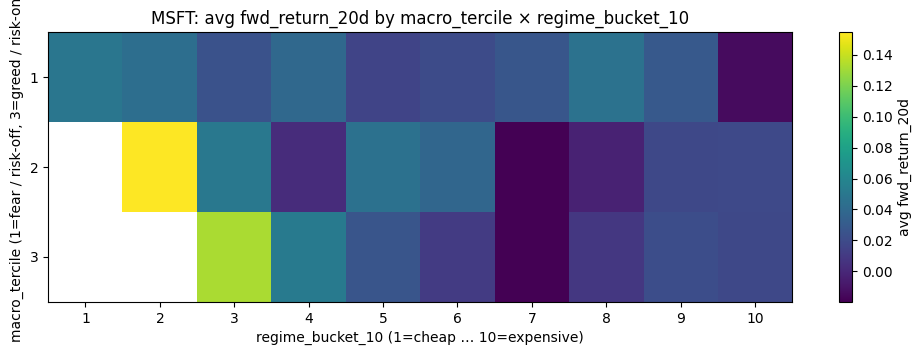

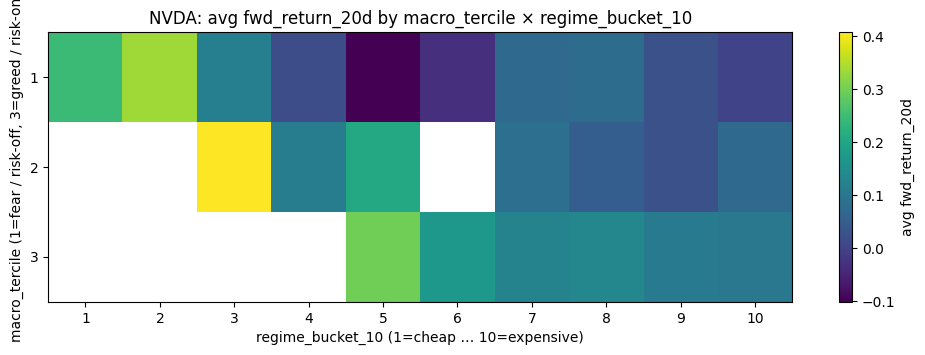

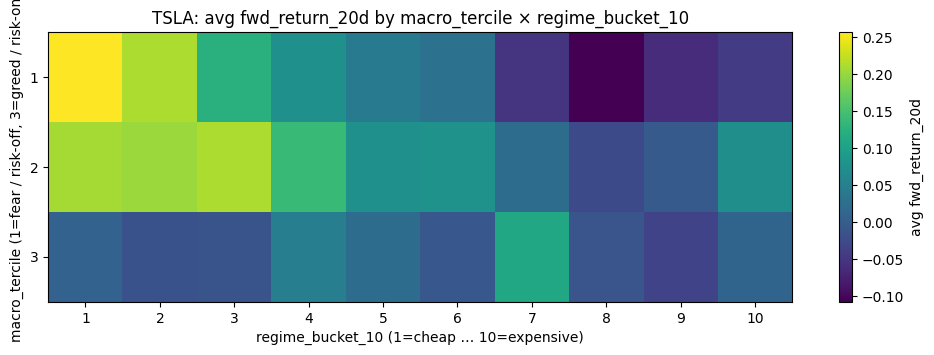

In [23]:
for t in sorted(df_macro["ticker"].unique()):
    sub = macro_summary[macro_summary["ticker"] == t]

    piv = sub.pivot(
        index="macro_tercile",
        columns="regime_bucket_10",
        values="avg_20d"
    )

    plt.figure(figsize=(12, 3.5))
    plt.imshow(piv.values, aspect="auto")
    plt.title(f"{t}: avg fwd_return_20d by macro_tercile × regime_bucket_10")
    plt.xlabel("regime_bucket_10 (1=cheap … 10=expensive)")
    plt.ylabel("macro_tercile (1=fear / risk-off, 3=greed / risk-on)")
    plt.colorbar(label="avg fwd_return_20d")

    plt.xticks(range(piv.shape[1]), piv.columns.tolist())
    plt.yticks(range(piv.shape[0]), piv.index.tolist())

    plt.show()
